In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from imageio import imwrite
from random import sample
plt.rcParams['image.cmap'] = 'gray' # plot as gray scale
s = plt.imshow #show

In [2]:
PATH = '/mnt/maxiv/common/ML-crystals/lyzo1_frames/'

In [3]:
def plot_images(images, titles=None, scatters=None):
    COLS = 2
    fig = plt.figure(figsize=(15, 40))
    for i, img in enumerate(images):
        ax = fig.add_subplot((len(images) // COLS) + 1, COLS, i + 1)
        if scatters is not None:
            ax.scatter(
                scatters[i][0], scatters[i][1], s=50, c='red', marker='o')
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(img)


def read_image(name, flag=cv2.IMREAD_COLOR):
    return cv2.imread(name, flag)


def read_sample_images(n=10, flag=cv2.IMREAD_COLOR):
    fls = os.listdir(PATH)
    fls = [PATH + f for f in fls]
    fls = sample(fls, n)
    return [read_image(f, flag) for f in fls], fls


def plot_cannys(n=10):
    imgs = read_sample_images(n, cv2.IMREAD_GRAYSCALE)
    cannys = [cv2.Canny(img, 45, 50, None, 3, True)[:-200, :] for img in imgs]
    scatters = [find_intensity_max(img) for img in cannys]
    titles = list(map(os.path.basename, fls))
    plot_images(imgs, titles, scatters)


def plot_histo(img, bins):
    hist, bins = np.histogram(img.ravel(), bins=bins, range=(0, 256))
    plt.hist(img.ravel(), bins=bins, range=(0, 256))


def remove_impossible_edges(edges: list, h: int, w: int,
                            h_scale=0.1, w_scale=0.3) -> np.ndarray:
    min_h, max_h = 0, round((1 - h_scale) * h)
    min_w, max_w = round(w_scale * w), round((1 - w_scale) * w)

    def filter_coords(coords):
        x, y = coords[0][0], coords[0][1]
        return (x > min_w and x < max_w) and y < max_h

    return np.array(list(filter(filter_coords, edges)))

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

def draw_bounding_box(imgs):
    boxes = []
    for img in imgs:
        gray = to_gray(img)
        gray = cv2.GaussianBlur(gray,(5,5),0)
        ret, thres = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        _, contours, hierarchy = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        h, w = thres.shape
        edges = max(contours, key=len)
        edges = remove_impossible_edges(edges, h, w, h_scale=0.1, w_scale=0.25)
        x, y, w, h = cv2.boundingRect(edges)
        y = 0
        copy = img.copy()
        cv2.drawContours(copy, [edges], 0, (0,255,0), 3)
        cv2.rectangle(copy, (x, y), (x + w, y + h), (255, 0, 0), 10)
        boxes.append(copy)
    return boxes

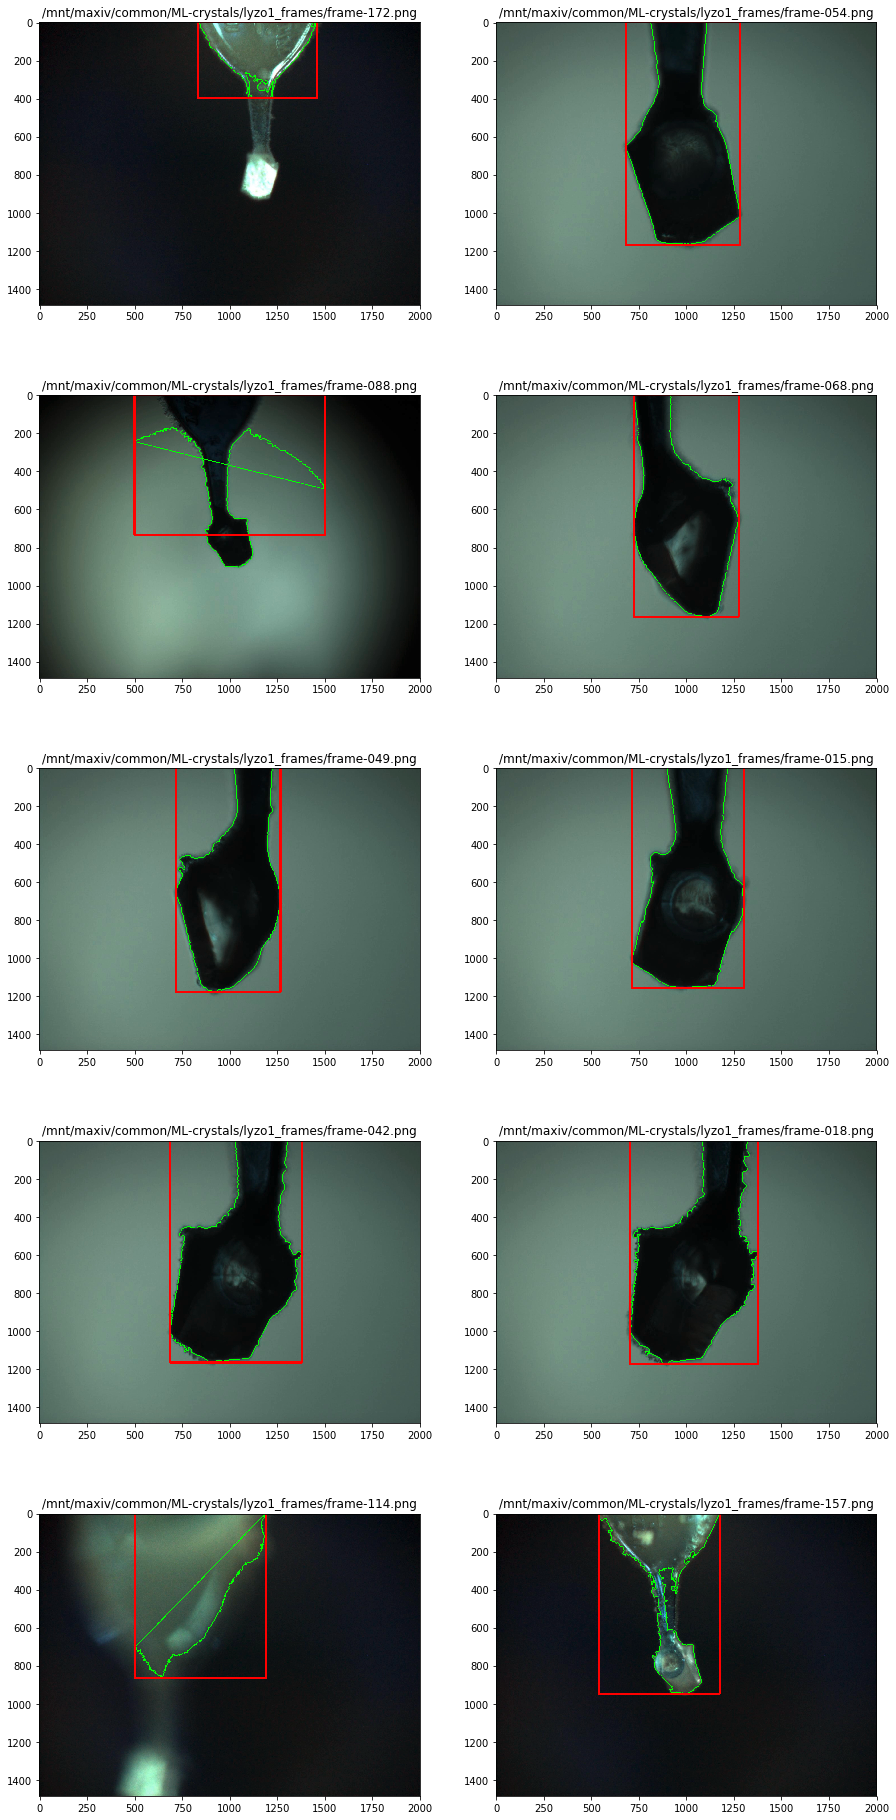

In [4]:
imgs, fls = read_sample_images(10)
boxes = draw_bounding_box(imgs)
plot_images(boxes, fls)